# CLIP: Connecting Text and Images

CLIP is an embedding model that generates comparable embeddings for both images and texts within the same vector space, enabling direct comparison between them.

CLIP and similar models can compare image and text embeddings in the same vector space, enabling tasks like:

**Zeroshot classification**<br/>
Match image embeddings with class descriptions to identify the closest class.

**Clustering** <br/>
Group images and keywords to find relevant sets.

**Search** <br/>
Quickly find related texts or images from large datasets.

**Generation** <br/>
Use multimodal embeddings to generate images (e.g., stable diffusion).

# How can CLIP generate multimodal embeddings?
img_sources: https://stock.adobe.com/

In [1]:
!wget -O puppy_with_snow.png https://i.pinimg.com/736x/86/ef/d4/86efd4dfa0f27885baf11c629f3007b5.jpg
!wget -O pixelated_kitty.png https://as2.ftcdn.net/v2/jpg/08/25/24/75/1000_F_825247574_bOIAO0T4pKTwh16kDOZX4qSvtkk7Sm3k.jpg
!wget -O supercar_on_the_road.png https://as1.ftcdn.net/v2/jpg/06/74/14/04/1000_F_674140405_Q9vJwhAeXRIeISYSTzFvgObwI5f223ae.jpg

--2024-06-25 03:57:37--  https://i.pinimg.com/736x/86/ef/d4/86efd4dfa0f27885baf11c629f3007b5.jpg
Resolving i.pinimg.com (i.pinimg.com)... 151.101.20.84, 2a04:4e42:5::84
Connecting to i.pinimg.com (i.pinimg.com)|151.101.20.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75023 (73K) [image/jpeg]
Saving to: ‘puppy_with_snow.png’

puppy_with_snow.png 100%[===================>]  73.26K  --.-KB/s    in 0.01s   

2024-06-25 03:57:37 (5.65 MB/s) - ‘puppy_with_snow.png’ saved [75023/75023]

--2024-06-25 03:57:37--  https://as2.ftcdn.net/v2/jpg/08/25/24/75/1000_F_825247574_bOIAO0T4pKTwh16kDOZX4qSvtkk7Sm3k.jpg
Resolving as2.ftcdn.net (as2.ftcdn.net)... 151.101.1.167, 151.101.65.167, 151.101.129.167, ...
Connecting to as2.ftcdn.net (as2.ftcdn.net)|151.101.1.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332414 (325K) [image/jpeg]
Saving to: ‘pixelated_kitty.png’

pixelated_kitty.png 100%[===================>] 324.62K  --.-KB/s    in 0.02s

In [2]:
#from urllib.request import urlopen
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch

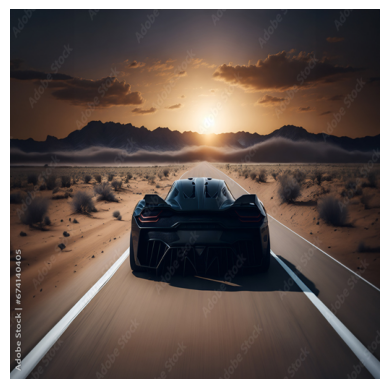

In [3]:
# -- Load an image
#image = Image.open('./puppy_with_snow.png')
#image = Image.open('./pixelated_kitty.png')
image = Image.open('./supercar_on_the_road.png')

image = image.resize((512, 512))

# -- Show
plt.imshow(image)
plt.axis('off')
plt.show()

# -- Caption
#caption = "a puppy playing in the snow"
#caption = "a pixelated image of a cute cat"
caption = "a supercar on the road with the sunset"

# OpenCLIP
https://github.com/mlfoundations/open_clip



In [4]:
!pip install transformers==4.41.2

In [5]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

To generate embeddings for an image and its caption using OpenCLIP, you need three models:
* a tokenizer for the text,
* a preprocessor for the image, and
* the main model to convert these processed inputs into embeddings

In [6]:
model_id = "openai/clip-vit-base-patch32"

# -- Load a tokenizer to preprocess the 'text'
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)

# -- Load a processor to preprocess the 'images'
processor = CLIPProcessor.from_pretrained(model_id)

# -- Main model for generating 'text and image embeddings'
model = CLIPModel.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Tokenizer
After loading the models, preprocessing the input becomes straightforward. <br/>
Let's begin with the tokenizer to see the results of preprocessing our input.

In [7]:
# -- Tokenize the caption about the input
inputs = tokenizer(caption, return_tensors="pt")

for k, v in inputs.items():
    print(f"{k}: {v}; {v.shape}") # (1, 8) = (num_sentance, sentance_length)

input_ids: tensor([[49406,   320, 27021,   525,   518,  1759,   593,   518,  3424, 49407]]); torch.Size([1, 10])
attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]); torch.Size([1, 10])


Values in `attention_mask`:
*  `1` indicates that the corresponding token should be attended to by the model, and
* `0` indicates that the token should be ignored (usually padding tokens).

Tensor shape in `attention_mask`:
* it matches the shape of the input sequence tensor (`input_ids`), ensuring that each token in the input sequence has a corresponding attention mask value.

Seeing the results, the input text has been converted to `input_ids`. <br/>
To see what those represent, let’s convert them to tokens:

In [8]:
# -- convert token_id to text for checking
print(tokenizer.convert_ids_to_tokens(torch.Tensor([49406])))
print(tokenizer.convert_ids_to_tokens(torch.Tensor([320])))
print(tokenizer.convert_ids_to_tokens(torch.Tensor([6829])))

['<|startoftext|>']
['a</w>']
['puppy</w>']


In [9]:
tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

['<|startoftext|>',
 'a</w>',
 'supercar</w>',
 'on</w>',
 'the</w>',
 'road</w>',
 'with</w>',
 'the</w>',
 'sunset</w>',
 '<|endoftext|>']

In the CLIP model, text is tokenized, with tokens marking the start and end of the text to differentiate it from potential image embeddings. <br/>
Unlike some other models, CLIP does not use the `[CLS]` token to represent the text; instead, the `[CLS]` token is used to represent the image embedding.

## Text embedding
Now that our caption is preprocessed, the next step is to generate the embedding.

In [10]:
# -- Create a text embedding
text_embedding = model.get_text_features(**inputs)

print(text_embedding.shape)
print(text_embedding.sum(-1))

torch.Size([1, 512])
tensor([8.6018], grad_fn=<SumBackward1>)


## Preprocess image
Before creating an image embedding, we need to preprocess the image to match the model's required size and shape <br/> using the previously created processor.

In [11]:
processed_image = processor(text=None, images=image, return_tensors='pt')['pixel_values']

print(processed_image.shape) # (B,C,H,W)

torch.Size([1, 3, 224, 224])


The original image was resized from 512x512 pixels to 224x224 pixels during preprocessing to meet the model's input requirements.

(224, 224, 3)


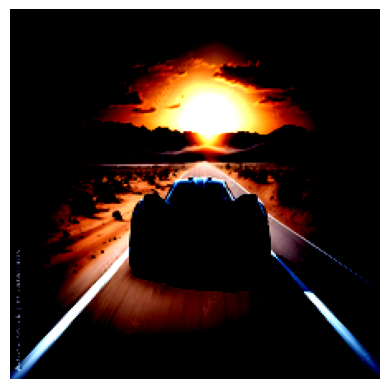

In [12]:
# -- Visualize
np_img = processed_image.squeeze(0)
np_img = np.einsum('ijk->jki', np_img)
print(np_img.shape)

plt.imshow(np_img)
plt.axis('off')
plt.show()

## Image embedding
To convert the preprocessed image into embeddings, we can use the model as we did previously for embeddings.

In [13]:
image_embedding = model.get_image_features(processed_image)
print(image_embedding.shape)

torch.Size([1, 512])


The resulting image embedding has the same shape as the text embedding, allowing for direct comparison.

## The probability
To determine if the caption matches the image, we can calculate the dot product of the embeddings and apply the softmax function to get the probability.

In [14]:
# -- Calculate the probability of the text belonging to the image
text_probs = (100.0 * image_embedding @ text_embedding.T).softmax(dim=-1)

print(text_probs)

tensor([[1.]], grad_fn=<SoftmaxBackward0>)


The model returns a score of 1, indicating it is certain the caption matches the image.

## Calculating the similarity
To further analyze similarity, we can normalize the embeddings before calculating the dot product, resulting in a value between 0 and 1.

In [15]:
# -- Normalize the embeddings
text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
image_embedding /= image_embedding.norm(dim=-1, keepdim=True)

In [16]:
# -- Calculate their similarity
text_embedding = text_embedding.detach().cpu().numpy()
image_embedding = image_embedding.detach().cpu().numpy()

score = np.dot(text_embedding, image_embedding.T)
print(score)

[[0.33880872]]


# Summary

In [40]:
!wget -O swan_and_duck.png https://as1.ftcdn.net/v2/jpg/03/19/39/26/1000_F_319392607_iGQGIxm6Uydj0R3rWJXNuqJtd24LqkJP.jpg
!wget -O chickens.png https://as1.ftcdn.net/v2/jpg/04/01/75/08/1000_F_401750896_7TNLyhRdBo3KT5pHe78S8YoQKXLo7zJ5.jpg
!wget -O birds_flying.png https://t3.ftcdn.net/jpg/02/10/17/32/240_F_210173237_39JkhlPSEfkl4WhLNgirxLPX2nO2HgLB.jpg

--2024-06-25 04:09:26--  https://as1.ftcdn.net/v2/jpg/03/19/39/26/1000_F_319392607_iGQGIxm6Uydj0R3rWJXNuqJtd24LqkJP.jpg
Resolving as1.ftcdn.net (as1.ftcdn.net)... 151.101.1.167, 151.101.65.167, 151.101.129.167, ...
Connecting to as1.ftcdn.net (as1.ftcdn.net)|151.101.1.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 323342 (316K) [image/jpeg]
Saving to: ‘swan_and_duck.png’

swan_and_duck.png   100%[===================>] 315.76K  --.-KB/s    in 0.03s   

2024-06-25 04:09:26 (10.1 MB/s) - ‘swan_and_duck.png’ saved [323342/323342]

--2024-06-25 04:09:26--  https://as1.ftcdn.net/v2/jpg/04/01/75/08/1000_F_401750896_7TNLyhRdBo3KT5pHe78S8YoQKXLo7zJ5.jpg
Resolving as1.ftcdn.net (as1.ftcdn.net)... 151.101.1.167, 151.101.65.167, 151.101.129.167, ...
Connecting to as1.ftcdn.net (as1.ftcdn.net)|151.101.1.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 301130 (294K) [image/jpeg]
Saving to: ‘chickens.png’

chickens.png        100%[==========

In [51]:
captions = ["There are many swans and ducks",
            "Chickens playing on the ground",
            "A pair of birds flying in the sky"]

img_list = ['./swan_and_duck.png',
            './chickens.png',
            './birds_flying.png']
images = [Image.open(path).resize((512, 512)) for path in img_list]

In [52]:
# -- Tokenize the caption about the input
inputs = tokenizer(captions, padding=True, truncation=True, return_tensors="pt")

for k, v in inputs.items():
    print(f"{k}: {v}; {v.shape}") # (num_sentance, sentance_length)


# -- Create a text embedding
text_embedding = model.get_text_features(**inputs)
print(text_embedding.shape)

input_ids: tensor([[49406,   997,   631,  1346, 19516,   537, 11202, 49407, 49407, 49407],
        [49406, 21658,  1629,   525,   518,  2461, 49407, 49407, 49407, 49407],
        [49406,   320,  4038,   539,  4337,  4610,   530,   518,  2390, 49407]]); torch.Size([3, 10])
attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]); torch.Size([3, 10])
torch.Size([3, 512])


* `padding=True`: Ensures that all sequences are padded to the same length.
* `truncation=True`: Truncates sequences that are longer than the maximum allowed length for the model.

In [53]:
# -- Preprocess images
processed_image = processor(text=None, images=images, return_tensors='pt')['pixel_values']

print(processed_image.shape) # (B,C,H,W)

# -- Image embedding
image_embedding = model.get_image_features(processed_image)
print(image_embedding.shape)

torch.Size([3, 3, 224, 224])
torch.Size([3, 512])


In [54]:
# == Calculate similarity scores ==

# -- Normalize the embeddings
text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
image_embedding /= image_embedding.norm(dim=-1, keepdim=True)


# -- Calculate their similarity
text_embedding = text_embedding.detach().cpu().numpy()
image_embedding = image_embedding.detach().cpu().numpy()

scores = np.dot(text_embedding, image_embedding.T)
print(scores)

[[0.29219258 0.19159813 0.2328229 ]
 [0.19664891 0.2980078  0.19303267]
 [0.20555359 0.18767497 0.2878392 ]]


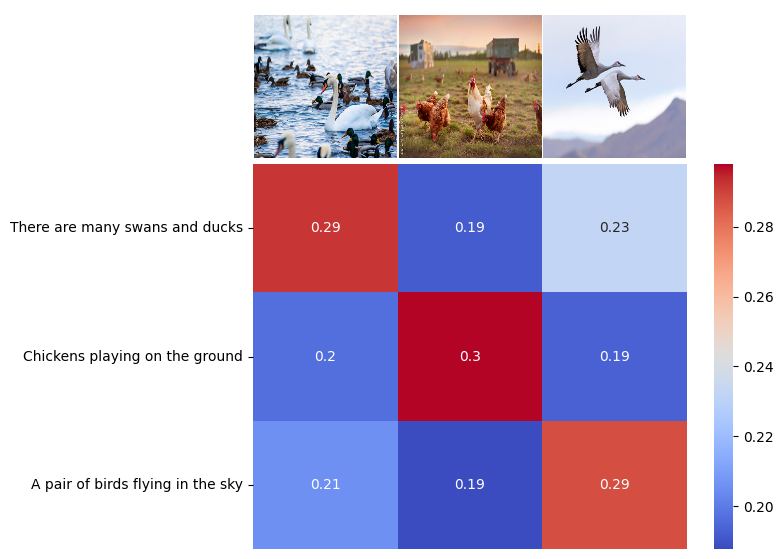

In [55]:
# == Visualization ==
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


# Create the heatmap
plt.figure(figsize=(7, 5))
ax = sns.heatmap(scores, annot=True, cmap='coolwarm', xticklabels=False, yticklabels=captions)


# Add images as xticklabels
for i, img in enumerate(images):
    imagebox = OffsetImage(np.array(img), zoom=0.2)  # Adjust zoom level as needed
    ab = AnnotationBbox(imagebox, (i + 0.5, len(captions) - 0.5), frameon=False, box_alignment=(0.5, -2.3))
    ax.add_artist(ab)


# Display the plot
plt.show()

***
# Reference
1. Wei, J., Tay, Y., Bommasani, R., Raffel, C., Zoph, B., Borgeaud, S., Yogatama, D., Bosma, M., Zhou, D., Metzler, D., & others (2022). Emergent abilities of large language models. arXiv preprint arXiv:2206.07682.

2. Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S., & others (2020). An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint arXiv:2010.11929.

3. Radford, A., Kim, J., Hallacy, C., Ramesh, A., Goh, G., Agarwal, S., Sastry, G., Askell, A., Mishkin, P., Clark, J., & others (2021). Learning transferable visual models from natural language supervision. In International conference on machine learning (pp. 8748–8763).

4. Schafer, R. (1954). Psychoanalytic interpretation in Rorschach testing: theory and application.

5. [Hands on Large Language Models](https://learning.oreilly.com/library/view/hands-on-large-language/9781098150952/ch05.html#transformers_for_vision), 2024.

# Tip
In `sentence-transformers`, there are a few CLIP-based models implemented that make it much easier to create embeddings.

In [57]:
!pip install sentence-transformers==3.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 5.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [60]:
from sentence_transformers import SentenceTransformer, util

# -- Load SBERT-compatible CLIP model
model = SentenceTransformer('clip-ViT-B-32')

# -- Encode the images
image_embeddings = model.encode(images)

# -- Encode the captions
text_embeddings = model.encode(captions)

# -- Compute cosine similarities
sim_matrix = util.cos_sim(image_embeddings, text_embeddings)
print(sim_matrix)

tensor([[0.2922, 0.1966, 0.2056],
        [0.1916, 0.2980, 0.1877],
        [0.2328, 0.1930, 0.2878]])
